In [1]:
## Sea Level Rise Model from EPS 261
import numpy as np
from numpy.polynomial.legendre import leggauss
import scipy
from scipy.io import loadmat
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import math
import pyshtools as pysh
import pandas as pd

In [42]:
# Parameters you will need
rhoi=917    # density of ice in kg/m^3
rhow=1000   # density of water in kg/m^3
a=6378100   # radius of the earth in m
Me=5.972e24 # mass of the earth in kg

# Specify maximum degree to which spherical transformations should be done
maxdeg = 256 # we'll use 64 here, which is relatively coarse; changed to 128 to make better

In [43]:
#Set up Gauss Legendre Grid
N = maxdeg
#x, w = leggauss(N) # Gauss Quadrature points (x) and weights (w)

def Legendre(n,x):
    x=np.asarray(x)
    c = np.zeros(n+1)
    c[-1]=1
    return np.polynomial.legendre.legval(x,c)


def DLegendre(n,x):
    x=np.asarray(x)
    if (n==0):
        return x*0
    elif (n==1):
        return x*0+1.0
    else:
        return (n/(x**2-1.0))*(x*Legendre(n,x)-Legendre(n-1,x))

def GaussLegendreWeights(N,x):
    W=[]
    xis=x
    W=2.0/( (1.0-xis**2)*(DLegendre(N,xis)**2) )
    return W
    
x = scipy.special.roots_legendre(N)[0]
print(x)
print(Legendre(N,x))
w = GaussLegendreWeights(N,x)

x_GL = np.arccos(x)*180/np.pi - 90; # cos(x_GL) are Quadrature points for P(cos(theta))
lon_GL = np.linspace(0,360,2*N+1);
lon_GL = lon_GL[0:-1];
lon_out,lat_out = np.meshgrid(lon_GL,x_GL);

[-0.99995605 -0.99976844 -0.99943094 -0.99894353 -0.99830627 -0.99751925
 -0.9965826  -0.99549645 -0.99426097 -0.99287634 -0.99134277 -0.98966049
 -0.98782975 -0.98585082 -0.98372401 -0.98144963 -0.97902802 -0.97645955
 -0.9737446  -0.97088358 -0.96787692 -0.96472506 -0.96142849 -0.95798769
 -0.95440319 -0.95067552 -0.94680523 -0.94279292 -0.93863917 -0.93434463
 -0.92990992 -0.92533572 -0.9206227  -0.91577159 -0.9107831  -0.90565798
 -0.90039701 -0.89500096 -0.88947066 -0.88380693 -0.87801062 -0.8720826
 -0.86602376 -0.859835   -0.85351727 -0.84707149 -0.84049865 -0.83379973
 -0.82697572 -0.82002767 -0.8129566  -0.80576357 -0.79844968 -0.79101601
 -0.78346368 -0.77579383 -0.76800759 -0.76010615 -0.75209069 -0.7439624
 -0.73572251 -0.72737226 -0.71891289 -0.71034568 -0.70167191 -0.69289289
 -0.68400992 -0.67502434 -0.66593751 -0.65675078 -0.64746552 -0.63808315
 -0.62860505 -0.61903266 -0.6093674  -0.59961074 -0.58976412 -0.57982904
 -0.56980697 -0.55969943 -0.54950793 -0.539234   -0.5

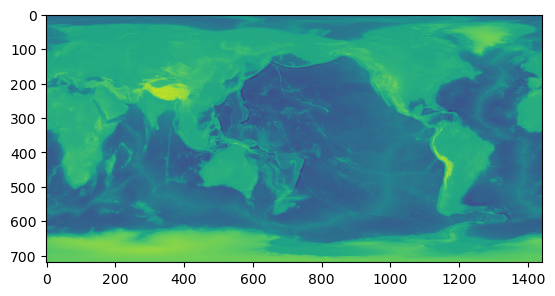

In [44]:
# Load in preloaded topography (includes ice on top of bedrock;
# from https://www.ngdc.noaa.gov/mgg/global/etopo2.html)
# Because we're using python, we have to extract the data from the MATLAB file
# The code below extracts each specific array and saves them under the same 
# names as used in the MATLAB version of the assignment
# mat = loadmat("Insert File Location Here/topo_Assignement.mat")
mat = loadmat("../data/topo_Assignement.mat")
lat_topo = np.array(mat["lat_topo"])
lon_topo = np.array(mat["lon_topo"])
topo_ice = np.array(mat["topo_ice"])
plt.imshow(np.flip(np.flip(topo_ice), axis=1))

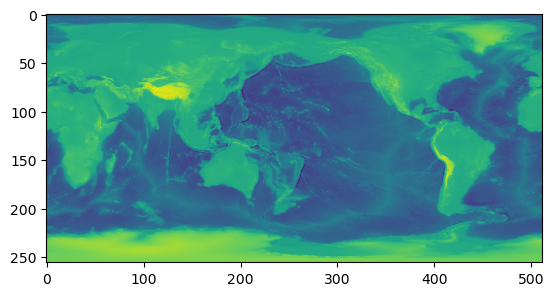

In [45]:
# Interpolate topography onto Gauss Legendre Grid
# we do this because we need the topography to be on a GL grid to be
# converted to spherical coordinates from spatial coordinates
x = interp2d(lon_topo, lat_topo, topo_ice)
topo_pres = x(lon_out[0,:], lat_out[:,0]) # question what do these mean
plt.imshow(np.flip(np.flip(topo_pres), axis=1)) #flips to get the right orientation

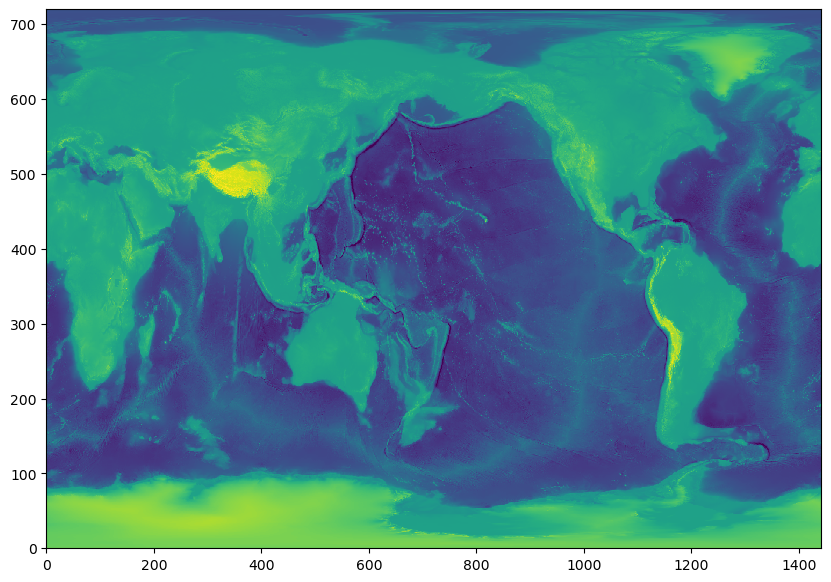

In [46]:
# plot to check the interpolation (don't need to turn this plot in)
# Feel free to change the plot dimensions in figsize=(x,y) to suit your preferences
fig = plt.figure(figsize=(10,7))
plt.pcolor(topo_ice, vmin=-7473, vmax=5731)
plt.show()

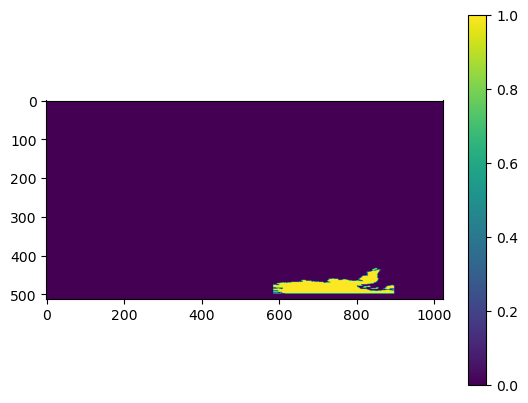

In [47]:
mat = loadmat("../data/ice_masks.mat")
ice_mask=np.array(mat["WAIS_mask"])
lon_mask = np.array(mat["lon_mask"])
lat_mask = np.array(mat["lat_mask"])
plt.imshow(ice_mask)
plt.colorbar()

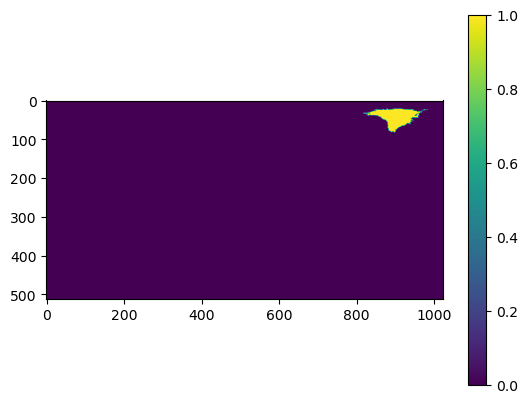

In [48]:
mat = loadmat("../data/ice_masks.mat")
ice_mask=np.array(mat["Greenland_mask"])
lon_mask = np.array(mat["lon_mask"])
lat_mask = np.array(mat["lat_mask"])
plt.imshow(ice_mask)
plt.colorbar()

In [51]:
## Calculate the fingerprints
# Make two functions to carry this calculation out. I've set up the input 
# variables for you and drafted a function for GrIS fingerprint calculation.
# You're welcome to make two different functions or modify the one I've
# drafted to calculate both the GrIS and WAIS fingerprint.

# You can either write the functions in this document or write them in a 
# seperate document and import the functions. To do this, create a python
# file in the same directory as this document and add
#      import fileName
#      from fileName import fp_calc_GrIS 
# to the imports at the top of this document

In [49]:
def fingerprint(ice_sheet,topo_ice,lon_out,lat_out,maxdeg,w,rhoi,rhow,a,Me,N):

    #########################################################
    #                                                       #
    #     I've marked to-do everywhere you need to fill     #
    #     in the code. Feel free to change the variable     #
    #     names                                             #
    #                                                       #
    #########################################################

    # Set constants needed for pysh to perform the spherical harmonic 
    # transform 
    lmax=N #used to be 361
    lreturn=N

    # Set-up grid and variables pysh uses for the spherical harmonic transform
    zero, w = pysh.expand.SHGLQ(lmax)                 # Transform variables
    latglq, longlq = pysh.expand.GLQGridCoord(lmax)   # Transform grid

    # Interpolate topo_ice from the input lon_out/lat_out grid onto the 
    # longlq/latglq grid
    # todo: interpolate onto old grid
    # todo: project onto new grid, save as topo_pres
    
    y = interp2d(lon_out, lat_out, topo_ice)
    topo_pres = y(longlq, latglq)
    
    C = topo_pres; 
    # todo:  set all land to 0
    C[C>0]=0
    # todo: set all ocean to 1
    C[C<0]=1
    
    # Do spherical harmonic transform of C into C_lm
    # we do this because we need the mask in spherical coordinates to calculate
    # the fingerprint
    c_lm = pysh.expand.SHExpandGLQC(C,w,zero,norm=1,csphase=1,lmax_calc=lreturn)


    # Load in ice masks
    mat = loadmat("../data/ice_masks.mat")
    lon_mask = np.array(mat["lon_mask"])
    lat_mask = np.array(mat["lat_mask"])
    ice_mask=np.array(mat[str(ice_sheet)])

    # Interpolate the mask on the the GL grid
    x=interp2d(lon_mask,lat_mask,ice_mask)
    ice_mask_interp = x(longlq, latglq)

    # Make sure the mask is all zeros and ones because the interpolation can
    # alter the values
    ice_mask_interp[ice_mask_interp<0]=0
    ice_mask_interp[ice_mask_interp>0]=1

    # Do spherical harmonic transform of Greenland mask
    #todo
    ice_mask_lm = pysh.expand.SHExpandGLQC(ice_mask_interp,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

    # Re-calculate C for use later in the code (we did this for you)
    topoglq2 = y(longlq,latglq)
    cilm_topo = pysh.expand.SHExpandGLQC(topoglq2,w,zero,norm=1,csphase=1,lmax_calc=lreturn)
    zero_down, w_down = pysh.expand.SHGLQ(lreturn)
    topo_down_grid = pysh.expand.MakeGridGLQC(cilm_topo,zero_down,lmax=lreturn,norm=1,csphase=1,lmax_calc=lreturn)
    topo_down = np.sign(topo_down_grid).real*np.abs(topo_down_grid)
    C=np.copy(topo_down)
    C[C>0]=0
    C[C<0]=1

    ## Start by making a a first guess about sea-level change
    # we don't know how sea-level changes with our ice melt scenario. Let's
    # make a simple first guess. Sea level grows uniformly (i.e., there is no
    # spatially-varying component) by 1cm due to ice melt.
    delta_S_guess = .01; # in meters
    eustatic = .01       # additionally save it as eustatic for later use in the code


    ## Use first guess to calculate delta_I, mask of the (uniform) ice height change

    # calculate the area of the ocean and area of ice first
    # the 1st value of a spherical harmonic xxx is the area because??
    area_ocean = c_lm[0][0,0].real
    area_ice = ice_mask_lm[0][0,0].real

    # Calculate ice height change
    # .01 m ocean water * rhow * ocean area = mass of water (kg)
    # mass of water / rhoi = ice volume (m^3)
    # [volume = area * height]
    # ice volume / area of GrIS ice = height of ice (m)
    height_ic = (delta_S_guess*rhow* area_ocean)/(rhoi*area_ice)  # todo

    # Calculate delta_I (project onto GrIS mask)
    delta_I = -height_ic * ice_mask_interp # todo

    # Spherical harmonic transform
    delta_I_lm = pysh.expand.SHExpandGLQC(delta_I,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

    ## Import the Elastic Love numbers
    # Love numbers are dimensionless numbers that represent the way a plantery 
    # body responds to changes in mass loads on its surface
    lovenumbers=np.loadtxt('../data/lovenumbers_python.txt')
    
    M_e=5.972*10**24   
    love_h=lovenumbers[:,1]
    love_k=lovenumbers[:,2]
    l=np.zeros([2,N+1,N+1])
    k_l=np.zeros([2,N+1,N+1])
    h_l=np.zeros([2,N+1,N+1])
    #l=np.zeros([2,65,65])
    #k_l=np.zeros([2,65,65])
    #h_l=np.zeros([2,65,65])
    i,j,k=l.shape
    for ii in np.arange(0,i):
        for jj in np.arange(0,j):
            for kk in np.arange(0,k):
                l[ii,jj,kk]=jj
    for ii in np.arange(0,i):
        for jj in np.arange(0,j):
            for kk in np.arange(0,k):
                k_l[ii,jj,kk]=love_k[jj]
    for ii in np.arange(0,i):
        for jj in np.arange(0,j):
            for kk in np.arange(0,k):
                h_l[ii,jj,kk]=love_h[jj]

    # Calculate Tl and El for use later in the code
    E_l=1+k_l-h_l
    T_l=(4*np.pi*a**3)/(M_e*(2*l+1))


    ## Calculate the initial delta_S, the first guess eustatic ocean height change.
    delta_S = -rhoi/rhow * delta_I_lm[0][0,0]/c_lm[0][0,0]*C#todo

    # spherical harmonic transform - why do we first have to do a transform of this?
    delta_S_lm = pysh.expand.SHExpandGLQC(delta_S,w,zero,norm=1,csphase=1,lmax_calc=lreturn) # todo

    ## Create a loop to iteratively calculate delta_SL, global sea-level variation

    #convergence criterion
    epsilon = 1e-4;
    # set a maximum iteration - don't want the loop to go forever & crash
    maxiter = 10;

    for i in np.arange(1,maxiter):
        #calculate delta SL
        temp =  rhoi* delta_I_lm+rhow*delta_S_lm # todo
        
        #convert from spherical back to spatial coordinates
        delta_SL = pysh.expand.MakeGridGLQC((temp*T_l*E_l),zero_down,lmax=lreturn,norm=1,csphase=1,lmax_calc=lreturn) #TlEl is the wrong size - I'll come back to that later, old code: TlEl*temp
        
        #calculate RO (project onto ocean mask)
        delta_RO = delta_SL*C # todo
        #convert to spherical harmonic coordinates
        delta_RO_lm = pysh.expand.SHExpandGLQC(delta_RO,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

        #calculate delta phi / g (eustatic sea-level change)
        delta_phi_g = - rhoi/rhow* delta_I_lm[0][0,0]/c_lm[0][0,0] - delta_RO_lm[0][0,0]/c_lm[0][0,0]
        #calculate new delta S
        delta_S_new = (delta_SL+delta_phi_g)*C # todo
        #delta_S_down = np.sign(delta_S_new).real*np.abs(delta_S_new)
        #convert to spherical harmonics to plug back in to first equation
        delta_S_lm_new =pysh.expand.SHExpandGLQC(delta_S_new,w,zero,norm=1,csphase=1,lmax_calc=lreturn) # todo

        #check convergence
        chi = np.max(np.abs(delta_S_new - delta_S))
        if chi < epsilon:
            print('Converged after ', str(i), ' iterations. Chi was ', str(np.real(chi)))
            print("")
            break

        delta_S = np.copy(delta_S_new) 
        delta_S_lm = np.copy(delta_S_lm_new)

    # Normalize your results against the eustatic

    # Calculate the final ocean height change from the loop (hint: the final
    # delta S not projected onto the ocean mask)
    sea_level = delta_SL+delta_phi_g # todo - don't want to project onto the ocean as before

    # Normalize sea level against the eustatic
    fingerprint = sea_level /0.01# todo

    return fingerprint.real

In [50]:
GrIS_fingerprint = fingerprint("Greenland_mask", topo_ice,lon_topo, lat_topo, maxdeg, w, rhoi, rhow, a, Me,N)
WAIS_fingerprint = fingerprint("WAIS_mask", topo_ice,lon_topo, lat_topo, maxdeg, w, rhoi, rhow, a, Me,N)

Converged after  5  iterations. Chi was  2.1633430653060157e-05

Converged after  5  iterations. Chi was  2.0400756398732123e-05



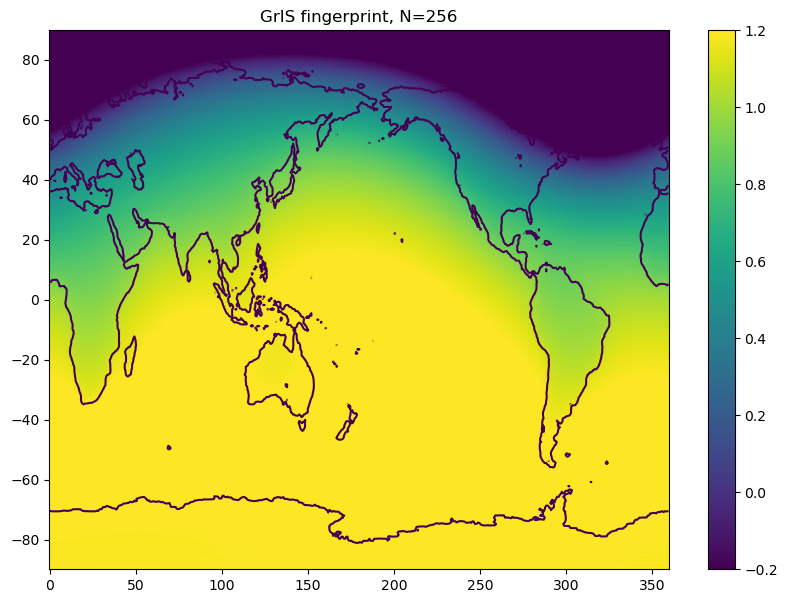

In [51]:
## Plot the GrIS fingerprint

fig = plt.figure(figsize=(10,7))

plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(GrIS_fingerprint.real[0:N,0:2*N])), vmin=-0.2, vmax=1.2) #x,y,c 
# put your normalized SL change here ^^
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres)),levels=[0])
plt.title('GrIS fingerprint, N=256')
plt.savefig('GrIS fingerprint_highres.png')
plt.show()

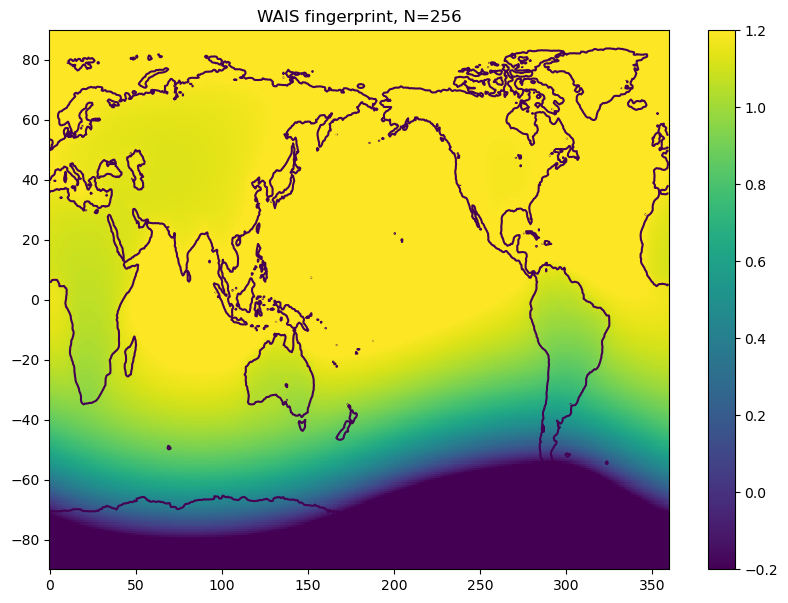

In [52]:
## Plot the WAIS fingerprint

fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(WAIS_fingerprint.real[0:N,0:2*N])), vmin=-0.2, vmax=1.2) #x,y,c 
# put your normalized SL change here ^^
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres)),levels=[0])
plt.plot()
plt.title('WAIS fingerprint, N=256')
plt.savefig('WAIS fingerprint_highres.png')
plt.show()
# 

In [53]:
## CALCULATING FINAL PERCENT

tide_gauge = pd.read_excel('../data/tide_gauge.xlsx') # importing in the converted excel file
tide_gauge.head() #looking at the first few rows

,Location,Sea-Level Rates (mm/yr),Latitude,East longitude
0,Nantucket,1.47,41.280,289.900
1,"Norfolk, VA",1.64,36.917,283.800
2,"Miami, FL",1.95,25.788,279.780
3,Tahiti,2.41,-17.670,210.580
4,Seychelles,2.26,-14.680,55.492


In [54]:
def slr(ice_sheet_fingerprint, lat,lon):
    """Get contribution from fingerprint"""
    lat_index = np.argmin(np.abs(np.flip(lat_out[:,1])-lat))
    lon_index = np.argmin(np.abs(lon_out[1,:]-lon))
    return ice_sheet_fingerprint[lat_index,lon_index] 

wais = []
gris = []
slr_true = []
for i in range(9):
    gris.append(slr(GrIS_fingerprint,tide_gauge.iloc[i,2],tide_gauge.iloc[i,3]))
    wais.append(slr(WAIS_fingerprint,tide_gauge.iloc[i,2],tide_gauge.iloc[i,3]))
    slr_true.append(tide_gauge.iloc[i,1])
gauge_prints = pd.DataFrame(list(zip(wais, gris)),
               columns =['wais', 'gris'])


A = pd.DataFrame(list(zip(wais, gris)),
               columns =['wais', 'gris'])

b = pd.DataFrame(list(zip(slr_true)),
               columns =['slr_true'])

x = np.linalg.solve(np.dot(np.transpose(A),A),np.dot(np.transpose(A),b)) #using matrix formula
percent_wais = x[0]/sum(x)*100
percent_gris = x[1]/sum(x)*100
print("The percent contribution from the Greenland Ice Sheet is: " + str(percent_gris))
print("The percent contribution from the West Antarctic Ice Sheet is: " + str(percent_wais))
#notebook, percent, and figures

The percent contribution from the Greenland Ice Sheet is: [50.01572461]
The percent contribution from the West Antarctic Ice Sheet is: [49.98427539]
